In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#there are some irregular lines in the data, so setting argument to get a note of which lines and skip them when reading in
accre_gpu = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv', on_bad_lines='warn')

b'Skipping line 124084: expected 12 fields, saw 13\nSkipping line 124809: expected 12 fields, saw 13\n'


In [3]:
#per our stakeholder, no need to include jobs with state of pending or running in our analysis, so dropping those 1258 rows
accre_gpu = accre_gpu.loc[~accre_gpu['STATE'].isin(['PENDING', 'RUNNING'])]

#stripping the 'M' from USEDMEM column and converting it to a numeric data type
accre_gpu['USEDMEM'] = accre_gpu['USEDMEM'].str.strip(to_strip='M').astype(float)

#converting REQTIME and USEDTIME columns to timedelta data types
accre_gpu['REQTIME'] = pd.to_timedelta(accre_gpu['REQTIME'].str.replace('-',' days '))
accre_gpu['USEDTIME'] = pd.to_timedelta(accre_gpu['USEDTIME'].str.replace('-',' days '))

#adding in a column that gives the difference in the time requested and time used
accre_gpu['time_dif'] = accre_gpu['REQTIME'] - accre_gpu['USEDTIME']

#adding in columns that provide versions of the other time columns but in minutes
accre_gpu['REQTIME_s'] = accre_gpu['REQTIME'].astype('timedelta64[s]')
accre_gpu['USEDTIME_s'] = accre_gpu['USEDTIME'].astype('timedelta64[s]')
accre_gpu['time_dif_s'] = accre_gpu['REQTIME_s'] - accre_gpu['USEDTIME_s']

accre_gpu

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
0,32880657,malanga,arline,18.66,2 days 00:00:00,0 days 00:13:13,1,2,1,pascal,0:0,COMPLETED,1 days 23:46:47,172800.0,793.0,172007.0
1,32880701,glasshouse,brady,0.00,0 days 05:00:00,0 days 00:00:22,1,3,1,maxwell,0:0,COMPLETED,0 days 04:59:38,18000.0,22.0,17978.0
2,32880718,glasshouse,brady,402.32,0 days 05:00:00,0 days 00:08:57,1,3,1,maxwell,0:0,COMPLETED,0 days 04:51:03,18000.0,537.0,17463.0
3,32880719,glasshouse,brady,417.62,0 days 20:00:00,0 days 05:09:46,1,1,1,pascal,0:0,COMPLETED,0 days 14:50:14,72000.0,18586.0,53414.0
4,32880720,glasshouse,brady,450.09,0 days 15:00:00,0 days 04:11:10,1,1,1,pascal,0:0,COMPLETED,0 days 10:48:50,54000.0,15070.0,38930.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,5 days 00:00:00,0 days 00:00:52,1,1,1,turing,0:0,COMPLETED,4 days 23:59:08,432000.0,52.0,431948.0
336934,46753820_26,harovin,porsha,5093.70,5 days 00:00:00,0 days 00:34:51,1,6,1,turing,0:0,COMPLETED,4 days 23:25:09,432000.0,2091.0,429909.0
336936,46753823,harovin,shannon,156.21,5 days 00:00:00,0 days 00:04:03,1,1,1,turing,0:0,COMPLETED,4 days 23:55:57,432000.0,243.0,431757.0
336942,46754095,harovin,shannon,2820.52,5 days 00:00:00,0 days 00:11:13,1,1,1,turing,0:0,COMPLETED,4 days 23:48:47,432000.0,673.0,431327.0


Doing a little exploration of the values in our columns

In [4]:
accre_gpu['STATE'].value_counts().sort_index(ascending=False)

OUT_OF_MEMORY               3
FAILED                    440
COMPLETED              283333
CANCELLED by 9201       41637
CANCELLED by 913169         3
                        ...  
CANCELLED by 153500         3
CANCELLED by 133418        23
CANCELLED by 111694        11
CANCELLED by 0              1
CANCELLED                 947
Name: STATE, Length: 96, dtype: int64

After dropping jobs marked as pending or running, these are the STATE column values that remain:   
- Out of memory
- Failed
- Completed
- Cancelled
- Cancelled by [numerical code] (92 versions of this)

Exploring the jobs that show some version of a Cancelled state

In [5]:
cancelled = accre_gpu.loc[accre_gpu['STATE'].str.contains('CANCELLED')]
cancelled

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
8,32880758,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
9,32880759,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
10,32880770,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
11,32880771,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
12,32880772,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336807,46745418,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
336830,46745779,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
336832,46745783,malanga,arline,0.0,2 days 00:00:00,0 days,0,2,1,pascal,0:0,CANCELLED by 9201,2 days 00:00:00,172800.0,0.0,172800.0
336880,46752723,glasshouse,ethen,0.0,0 days 04:00:00,0 days,1,6,1,turing,0:0,CANCELLED by 899035,0 days 04:00:00,14400.0,0.0,14400.0


There are 51,916 jobs that have a STATE value of some version of Cancelled. May be worth looking at how much time and memory was spent on these jobs

In [6]:
#taking a quick look just to see how many of the cancelled jobs ran for more than an hour
cancelled.loc[cancelled['USEDTIME'] > '01:00:00'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
count,295.000000,295,295,295.000000,295.000000,295.000000,295,2.950000e+02,295.000000,2.950000e+02
mean,7370.163051,3 days 21:08:32.542372881,2 days 10:20:31.593220338,1.471186,5.501695,4.962712,1 days 10:48:00.949152542,3.353125e+05,210031.593220,1.252809e+05
std,11668.831393,1 days 22:49:35.663623084,2 days 01:15:01.972778381,1.016037,5.861714,4.923424,2 days 00:51:34.763658105,1.685757e+05,177301.972778,1.758948e+05
min,0.000000,0 days 01:00:00,0 days 01:03:22,1.000000,1.000000,1.000000,-1 days +23:51:22,3.600000e+03,3802.000000,-5.180000e+02
25%,203.060000,2 days 00:00:00,0 days 07:57:40,1.000000,1.000000,1.000000,-1 days +23:59:40,1.728000e+05,28660.000000,-2.000000e+01
50%,1236.400000,5 days 00:00:00,2 days 00:00:38,1.000000,4.000000,4.000000,0 days 01:46:54,4.320000e+05,172838.000000,6.414000e+03
75%,9216.925000,5 days 00:00:00,5 days 00:00:02,1.000000,8.000000,5.000000,2 days 17:31:53.500000,4.320000e+05,432002.000000,2.359135e+05
max,54338.440000,15 days 00:00:00,9 days 23:59:54,4.000000,33.000000,16.000000,13 days 07:38:06,1.296000e+06,863994.000000,1.150686e+06


Only 295 Cancelled jobs ran for longer than an hour but the mean and median for these is around 2 days, so, again, may be worth exploring to better understand them and see if such instances can be avoided

In [33]:
cancelled.loc[cancelled['USEDTIME'] > '01:00:00'].groupby('STATE')['EXITCODE'].value_counts()

STATE                EXITCODE
CANCELLED            0:9         114
                     0:15         96
                     0:0          53
                     0:6           9
                     1:0           2
                     0:7           1
CANCELLED by 505355  0:9           9
CANCELLED by 756088  0:9           1
CANCELLED by 785491  0:9           6
CANCELLED by 859439  0:9           1
CANCELLED by 885613  0:9           3
Name: EXITCODE, dtype: int64

Do these exit codes suggest that there tends to be an issue with the environment that is associated with the job being cancelled?

Shifting gears back to the primary dataset

In [8]:
#per our stakeholder, CANCELLED jobs can be excluded from the main analysis, so dropping them from the primary dataframe
accre_gpu = accre_gpu.loc[~accre_gpu['STATE'].str.contains('CANCELLED')]
accre_gpu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283776 entries, 0 to 336948
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype          
---  ------      --------------   -----          
 0   JOBID       283776 non-null  object         
 1   ACCOUNT     283776 non-null  object         
 2   USER        283776 non-null  object         
 3   USEDMEM     283776 non-null  float64        
 4   REQTIME     283776 non-null  timedelta64[ns]
 5   USEDTIME    283776 non-null  timedelta64[ns]
 6   NODES       283776 non-null  int64          
 7   CPUS        283776 non-null  int64          
 8   GPUS        283776 non-null  int64          
 9   PARTITION   283776 non-null  object         
 10  EXITCODE    283776 non-null  object         
 11  STATE       283776 non-null  object         
 12  time_dif    283776 non-null  timedelta64[ns]
 13  REQTIME_s   283776 non-null  float64        
 14  USEDTIME_s  283776 non-null  float64        
 15  time_dif_s  283776 non-null  float

In [9]:
accre_gpu['EXITCODE'].value_counts()

0:0      283334
1:0         395
2:0          17
127:0         6
7:0           6
13:0          5
126:0         4
16:0          3
0:125         3
33:0          2
9:0           1
Name: EXITCODE, dtype: int64

In [10]:
#Taking a look at the exit codes associated with failed jobs
accre_gpu.loc[accre_gpu['STATE'] == 'FAILED']['EXITCODE'].value_counts()

1:0      395
2:0       17
127:0      6
7:0        6
13:0       5
126:0      4
16:0       3
33:0       2
0:0        1
9:0        1
Name: EXITCODE, dtype: int64

Based on exit codes, the failed jobs seem to fail due to user side issues

In [11]:
#looking at overall distribution of values for our numerical/time columns
accre_gpu.describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
count,283776.000000,283776,283776,283776.000000,283776.000000,283776.000000,283776,2.837760e+05,2.837760e+05,2.837760e+05
mean,2261.094059,1 days 00:10:23.951496955,0 days 01:35:33.293763390,1.005490,1.724092,1.089324,0 days 22:34:50.657733564,8.702395e+04,5.733294e+03,8.129066e+04
std,6639.863578,1 days 11:32:30.215890212,0 days 09:56:52.751470501,0.128331,1.824853,0.859311,1 days 09:52:09.035932303,1.279502e+05,3.581275e+04,1.219290e+05
min,0.000000,0 days 00:01:00,0 days 00:00:00,0.000000,1.000000,1.000000,-49 days +01:13:05,6.000000e+01,0.000000e+00,-4.229215e+06
25%,7.530000,0 days 10:00:00,0 days 00:00:22,1.000000,1.000000,1.000000,0 days 05:59:43,3.600000e+04,2.200000e+01,2.158300e+04
50%,1176.710000,0 days 10:00:00,0 days 00:03:19,1.000000,1.000000,1.000000,0 days 09:57:06,3.600000e+04,1.990000e+02,3.582600e+04
75%,2179.940000,0 days 12:00:00,0 days 00:09:08,1.000000,2.000000,1.000000,0 days 11:39:33,4.320000e+04,5.480000e+02,4.197300e+04
max,371247.350000,15 days 00:00:00,49 days 02:46:55,15.000000,120.000000,60.000000,11 days 09:46:10,1.296000e+06,4.243615e+06,9.855700e+05


In [12]:
#interestingly, values slightly lower if only looking at completed jobs (no failed(440) or out of memory(3))
accre_gpu.loc[accre_gpu['STATE'] == 'COMPLETED'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
count,283333.000000,283333,283333,283333.000000,283333.000000,283333.000000,283333,2.833330e+05,283333.000000,283333.000000
mean,2240.911704,1 days 00:05:59.687223161,0 days 01:34:19.081218919,1.004779,1.713161,1.079627,0 days 22:31:40.606004242,8.675969e+04,5659.081219,81100.606004
std,6434.562929,1 days 11:29:35.285143482,0 days 09:38:43.694361307,0.115222,1.758140,0.783146,1 days 09:45:08.955143504,1.277753e+05,34723.694361,121508.955144
min,0.000000,0 days 00:01:00,0 days 00:00:00,1.000000,1.000000,1.000000,-1 days +03:56:07,6.000000e+01,0.000000,-72233.000000
25%,7.530000,0 days 10:00:00,0 days 00:00:22,1.000000,1.000000,1.000000,0 days 05:59:42,3.600000e+04,22.000000,21582.000000
50%,1176.880000,0 days 10:00:00,0 days 00:03:19,1.000000,1.000000,1.000000,0 days 09:57:06,3.600000e+04,199.000000,35826.000000
75%,2179.520000,0 days 12:00:00,0 days 00:09:06,1.000000,2.000000,1.000000,0 days 11:37:36,4.320000e+04,546.000000,41856.000000
max,371247.350000,15 days 00:00:00,8 days 03:15:34,15.000000,120.000000,60.000000,11 days 09:46:10,1.296000e+06,702934.000000,985570.000000


So much skew!

In [13]:
#looking at the longest running jobs
accre_gpu.nlargest(20, 'USEDTIME')

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
317705,45364680,glasshouse,daryl,0.00,0 days 04:00:00,49 days 02:46:55,1,2,1,pascal,0:0,FAILED,-49 days +01:13:05,14400.0,4243615.0,-4229215.0
82721,40954771,glasshouse,mel,7465.59,12 days 00:00:00,8 days 03:15:34,3,21,16,pascal,0:0,COMPLETED,3 days 20:44:26,1036800.0,702934.0,333866.0
330597,45754711_9,harovin,porsha,17932.89,5 days 00:00:00,5 days 00:04:26,1,6,1,turing,0:0,COMPLETED,-1 days +23:55:34,432000.0,432266.0,-266.0
330598,45754711_10,harovin,porsha,18744.37,5 days 00:00:00,5 days 00:04:25,1,6,1,turing,0:0,COMPLETED,-1 days +23:55:35,432000.0,432265.0,-265.0
59290,35860195,harovin,porsha,4045.17,5 days 00:00:00,5 days 00:02:24,1,3,1,turing,0:0,COMPLETED,-1 days +23:57:36,432000.0,432144.0,-144.0
59321,35863149,harovin,porsha,4550.14,5 days 00:00:00,5 days 00:01:21,1,3,1,turing,0:0,COMPLETED,-1 days +23:58:39,432000.0,432081.0,-81.0
60349,36303220_30,harovin,porsha,3938.44,5 days 00:00:00,5 days 00:01:14,1,3,1,turing,0:0,COMPLETED,-1 days +23:58:46,432000.0,432074.0,-74.0
60347,36303220_28,harovin,porsha,3944.94,5 days 00:00:00,5 days 00:01:13,1,3,1,turing,0:0,COMPLETED,-1 days +23:58:47,432000.0,432073.0,-73.0
60348,36303220_29,harovin,porsha,3997.92,5 days 00:00:00,5 days 00:01:13,1,3,1,turing,0:0,COMPLETED,-1 days +23:58:47,432000.0,432073.0,-73.0
60160,36098354_13,harovin,porsha,4165.07,5 days 00:00:00,5 days 00:01:06,1,3,1,turing,0:0,COMPLETED,-1 days +23:58:54,432000.0,432066.0,-66.0


Interesting that the very longest failed after running for 49 days, but used no memory?   

Also, for all these jobs that ran for just over 5 days, did they really complete within a few minutes of hitting that 5 day mark, or were they forced to "complete" because they hit the requested time amount?

In [14]:
accre_gpu.loc[accre_gpu['USEDTIME'] > '24:00:00']

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
6,32880722,glasshouse,brady,0.00,3 days 12:00:00,3 days 12:00:07,1,1,1,pascal,0:0,COMPLETED,-1 days +23:59:53,302400.0,302407.0,-7.0
327,32884086,glasshouse,miya,374.89,5 days 00:00:00,1 days 08:38:34,1,1,1,pascal,0:0,COMPLETED,3 days 15:21:26,432000.0,117514.0,314486.0
540,32885557,malanga,alwilda,7572.38,2 days 00:00:00,1 days 05:49:07,1,2,1,pascal,0:0,COMPLETED,0 days 18:10:53,172800.0,107347.0,65453.0
784,32888937,virginia,almond,0.00,2 days 12:00:00,2 days 12:00:10,1,18,3,turing,0:0,COMPLETED,-1 days +23:59:50,216000.0,216010.0,-10.0
1004,32891492,glasshouse,erick,241.82,4 days 04:00:00,4 days 04:00:26,1,1,1,pascal,0:0,COMPLETED,-1 days +23:59:34,360000.0,360026.0,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335954,46585013,glasshouse,makala,22665.14,3 days 00:00:00,3 days 00:00:28,1,4,1,turing,0:0,COMPLETED,-1 days +23:59:32,259200.0,259228.0,-28.0
335986,46586557_36,harovin,porsha,39073.00,5 days 00:00:00,1 days 22:08:42,1,6,1,turing,0:0,COMPLETED,3 days 01:51:18,432000.0,166122.0,265878.0
336004,46594210,pecans,ramona,2966.58,2 days 00:00:00,1 days 21:11:57,1,2,1,pascal,0:0,COMPLETED,0 days 02:48:03,172800.0,162717.0,10083.0
336005,46594666,glasshouse,santiago,82.06,2 days 00:00:00,2 days 00:00:29,1,24,4,turing,0:0,COMPLETED,-1 days +23:59:31,172800.0,172829.0,-29.0


Approximately 2.8% of jobs that show a status of completed, failed, or out of memory run for longer than 12 hours  
Approximately 1.6% run longer than 24 hours

In [15]:
#looking at the stats for jobs that failed or ran out of memory
accre_gpu.loc[accre_gpu['STATE'] != 'COMPLETED'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
count,443.000000,443,443,443.000000,443.000000,443.000000,443,443.000000,4.430000e+02,4.430000e+02
mean,15169.281535,2 days 23:07:21.534988713,0 days 14:46:37.995485327,1.460497,8.715576,7.291196,2 days 08:20:43.539503386,256041.534989,5.319800e+04,2.028435e+05
std,39969.407619,1 days 11:34:52.247900874,2 days 13:01:35.573544238,1.362107,10.367911,6.505382,2 days 23:09:27.789831443,128092.247901,2.196956e+05,2.561678e+05
min,0.000000,0 days 00:10:00,0 days 00:00:00,0.000000,1.000000,1.000000,-49 days +01:13:05,600.000000,0.000000e+00,-4.229215e+06
25%,7.410000,1 days 06:00:00,0 days 00:00:02,1.000000,1.000000,1.000000,0 days 19:41:21,108000.000000,2.000000e+00,7.088100e+04
50%,210.880000,3 days 08:00:00,0 days 00:07:39,1.000000,4.000000,8.000000,3 days 06:22:07,288000.000000,4.590000e+02,2.821270e+05
75%,7270.565000,4 days 00:00:00,0 days 08:10:46,2.000000,12.000000,10.000000,3 days 23:40:30,345600.000000,2.944600e+04,3.444300e+05
max,310280.900000,5 days 00:00:00,49 days 02:46:55,9.000000,70.000000,32.000000,5 days 00:00:00,432000.000000,4.243615e+06,4.320000e+05


In [16]:
#total number of failed/out of memory jobs
accre_gpu.loc[accre_gpu['STATE'] != 'COMPLETED'].groupby('PARTITION')['JOBID'].count()

PARTITION
maxwell    117
pascal     230
turing      96
Name: JOBID, dtype: int64

In [17]:
#total amount of time spent on failed/out of memory jobs
accre_gpu.loc[accre_gpu['STATE'] != 'COMPLETED'].groupby('PARTITION')['USEDTIME'].sum()

PARTITION
maxwell    59 days 18:38:16
pascal    159 days 07:28:02
turing     53 days 16:12:14
Name: USEDTIME, dtype: timedelta64[ns]

In [18]:
#total amount of memory used on failed/out of memory jobs
accre_gpu.loc[accre_gpu['STATE'] != 'COMPLETED'].groupby('PARTITION')['USEDMEM'].sum()

PARTITION
maxwell    1061483.11
pascal     3705383.13
turing     1953125.48
Name: USEDMEM, dtype: float64

In [19]:
#total number of GPUs used on failed/out of memory jobs
accre_gpu.loc[accre_gpu['STATE'] != 'COMPLETED'].groupby('PARTITION')['GPUS'].sum()

PARTITION
maxwell    1060
pascal     1481
turing      689
Name: GPUS, dtype: int64

Looking at general stats for completed/failed/out of memory jobs for each partition

In [20]:
accre_gpu.loc[accre_gpu['PARTITION'] == 'maxwell'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
count,127160.000000,127160,127160,127160.000000,127160.000000,127160.000000,127160,1.271600e+05,127160.000000,127160.000000
mean,1052.447286,0 days 15:06:01.807172066,0 days 00:29:55.219479396,1.003154,1.146005,1.052359,0 days 14:36:06.587692670,5.436181e+04,1795.219479,52566.587693
std,2331.444456,0 days 22:31:52.030182916,0 days 05:24:04.844920416,0.092062,1.344548,0.632417,0 days 21:36:57.156954558,8.111203e+04,19444.844920,77817.156955
min,0.000000,0 days 00:01:00,0 days 00:00:00,0.000000,1.000000,1.000000,-1 days +23:58:49,6.000000e+01,0.000000,-71.000000
25%,5.540000,0 days 10:00:00,0 days 00:00:10,1.000000,1.000000,1.000000,0 days 09:56:19,3.600000e+04,10.000000,35779.000000
50%,1113.155000,0 days 10:00:00,0 days 00:03:01,1.000000,1.000000,1.000000,0 days 09:57:05,3.600000e+04,181.000000,35825.000000
75%,1315.842500,0 days 10:00:00,0 days 00:03:45,1.000000,1.000000,1.000000,0 days 09:59:52,3.600000e+04,225.000000,35992.000000
max,119399.180000,15 days 00:00:00,5 days 00:00:32,10.000000,80.000000,40.000000,11 days 09:46:10,1.296000e+06,432032.000000,985570.000000


In [21]:
accre_gpu.loc[accre_gpu['PARTITION'] == 'pascal'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
count,81544.000000,81544,81544,81544.000000,81544.000000,81544.000000,81544,8.154400e+04,8.154400e+04,8.154400e+04
mean,2692.467733,1 days 23:55:11.727901501,0 days 02:52:43.346720788,1.012214,1.506892,1.169050,1 days 21:02:28.381180712,1.725117e+05,1.036335e+04,1.621484e+05
std,6611.661783,1 days 20:18:05.288080371,0 days 13:10:13.568448855,0.194407,1.605479,1.260511,1 days 19:26:01.035839873,1.594853e+05,4.741357e+04,1.563610e+05
min,0.000000,0 days 00:01:00,0 days 00:00:00,0.000000,1.000000,1.000000,-49 days +01:13:05,6.000000e+01,0.000000e+00,-4.229215e+06
25%,164.490000,0 days 10:00:00,0 days 00:02:36,1.000000,1.000000,1.000000,0 days 09:54:37,3.600000e+04,1.560000e+02,3.567700e+04
50%,1363.295000,1 days 00:00:00,0 days 00:08:36,1.000000,1.000000,1.000000,0 days 23:58:52,8.640000e+04,5.160000e+02,8.633200e+04
75%,3255.512500,3 days 00:00:00,0 days 00:30:54,1.000000,2.000000,1.000000,2 days 23:57:12,2.592000e+05,1.854000e+03,2.590320e+05
max,248467.890000,12 days 00:00:00,49 days 02:46:55,15.000000,120.000000,60.000000,5 days 00:00:00,1.036800e+06,4.243615e+06,4.320000e+05


In [22]:
accre_gpu.loc[accre_gpu['PARTITION'] == 'turing'].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
count,75072.000000,75072,75072,75072.000000,75072.000000,75072.000000,75072,75072.000000,75072.000000,75072.000000
mean,3839.786365,0 days 13:44:50.690537084,0 days 02:02:54.551324062,1.002145,2.939205,1.065337,0 days 11:41:56.139213022,49490.690537,7374.551324,42116.139213
std,10237.039246,1 days 06:22:33.444369635,0 days 11:29:55.807817987,0.082314,2.152269,0.614944,1 days 02:51:34.357085611,109353.444370,41395.807818,96694.357086
min,0.000000,0 days 00:01:00,0 days 00:00:00,1.000000,1.000000,1.000000,-1 days +03:56:07,60.000000,0.000000,-72233.000000
25%,7.410000,0 days 00:30:00,0 days 00:00:14,1.000000,2.000000,1.000000,0 days 00:27:16,1800.000000,14.000000,1636.000000
50%,1253.960000,0 days 01:00:00,0 days 00:03:02,1.000000,2.000000,1.000000,0 days 00:59:47,3600.000000,182.000000,3587.000000
75%,2420.410000,0 days 12:00:00,0 days 00:15:32,1.000000,4.000000,1.000000,0 days 09:59:53,43200.000000,932.000000,35993.000000
max,371247.350000,11 days 00:00:00,5 days 00:04:26,10.000000,80.000000,40.000000,9 days 22:04:06,950400.000000,432266.000000,857046.000000


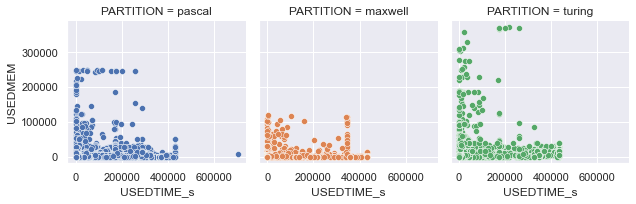

In [24]:
#plotting USEDTIME(in minutes) against USEDMEM (dropping that 1 outlier that failed after 49 days)
sns.set(rc={"figure.figsize":(12, 8)})
g = sns.FacetGrid(accre_gpu.loc[accre_gpu['USEDTIME']<'49days'], col='PARTITION', hue='PARTITION')
g.map_dataframe(sns.scatterplot, 
      x='USEDTIME_s', 
      y="USEDMEM");

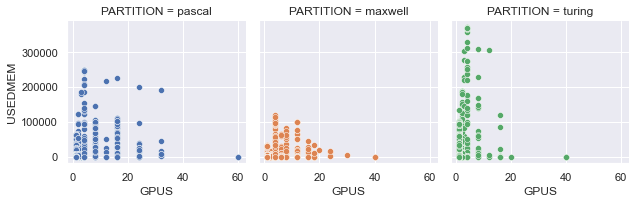

In [25]:
#plotting GPUs against USEDMEM (dropping that 1 outlier that failed after 49 days)
sns.set(rc={"figure.figsize":(12, 8)})
g = sns.FacetGrid(accre_gpu.loc[accre_gpu['USEDTIME']<'49days'], col='PARTITION', hue='PARTITION')
g.map_dataframe(sns.scatterplot, 
      x='GPUS', 
      y="USEDMEM");

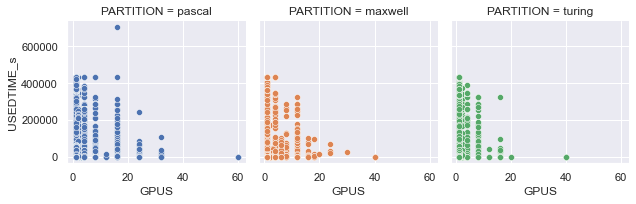

In [27]:
#plotting GPUs against USEDTIME(in minutes) (dropping that 1 outlier that failed after 49 days)
sns.set(rc={"figure.figsize":(12, 8)})
g = sns.FacetGrid(accre_gpu.loc[accre_gpu['USEDTIME']<'49days'], col='PARTITION', hue='PARTITION')
g.map_dataframe(sns.scatterplot, 
      x='GPUS', 
      y="USEDTIME_s");

Curious about jobs that ran as long or longer than requested time

In [29]:
accre_gpu[accre_gpu['USEDTIME'] >= accre_gpu['REQTIME']]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
6,32880722,glasshouse,brady,0.00,3 days 12:00:00,3 days 12:00:07,1,1,1,pascal,0:0,COMPLETED,-1 days +23:59:53,302400.0,302407.0,-7.0
80,32881540,virginia,garrett,4039.36,0 days 02:00:00,0 days 02:00:05,1,6,1,turing,0:0,COMPLETED,-1 days +23:59:55,7200.0,7205.0,-5.0
91,32882556,virginia,garrett,55.39,0 days 06:00:00,0 days 06:00:05,1,6,1,turing,0:0,COMPLETED,-1 days +23:59:55,21600.0,21605.0,-5.0
92,32882567,virginia,garrett,281.12,0 days 06:00:00,0 days 06:00:05,1,6,1,turing,0:0,COMPLETED,-1 days +23:59:55,21600.0,21605.0,-5.0
93,32882568,virginia,garrett,57.32,0 days 06:00:00,0 days 06:00:17,1,6,1,turing,0:0,COMPLETED,-1 days +23:59:43,21600.0,21617.0,-17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336505,46652721,glasshouse,miya,82.70,0 days 10:00:00,0 days 10:00:26,1,1,1,pascal,0:0,COMPLETED,-1 days +23:59:34,36000.0,36026.0,-26.0
336628,46655849,glasshouse,miya,72.32,0 days 10:00:00,0 days 10:00:01,1,1,1,pascal,0:0,COMPLETED,-1 days +23:59:59,36000.0,36001.0,-1.0
336630,46655855,virginia,diandra,407.18,0 days 02:00:00,0 days 02:00:06,1,6,1,turing,0:0,COMPLETED,-1 days +23:59:54,7200.0,7206.0,-6.0
336808,46745423,virginia,diandra,464.67,0 days 04:00:00,0 days 04:00:01,1,6,1,turing,0:0,COMPLETED,-1 days +23:59:59,14400.0,14401.0,-1.0


In [30]:
accre_gpu[accre_gpu['USEDTIME'] >= accre_gpu['REQTIME']].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,time_dif,REQTIME_s,USEDTIME_s,time_dif_s
count,2959.000000,2959,2959,2959.000000,2959.000000,2959.000000,2959,2959.000000,2.959000e+03,2.959000e+03
mean,8833.866164,2 days 01:16:11.618790131,2 days 01:41:08.390672524,1.014532,4.078743,1.542413,-1 days +23:35:03.228117608,177371.618790,1.788684e+05,-1.496772e+03
std,29773.660800,2 days 02:06:12.891153104,2 days 06:13:35.984088836,0.198349,4.775368,1.579794,0 days 21:36:04.117181494,180372.891153,1.952160e+05,7.776412e+04
min,0.000000,0 days 00:01:00,0 days 00:01:00,1.000000,1.000000,1.000000,-49 days +01:13:05,60.000000,6.000000e+01,-4.229215e+06
25%,263.560000,0 days 04:00:00,0 days 04:00:03,1.000000,1.000000,1.000000,-1 days +23:59:34,14400.000000,1.440300e+04,-2.600000e+01
50%,2477.090000,1 days 00:00:00,1 days 00:00:26,1.000000,2.000000,1.000000,-1 days +23:59:41,86400.000000,8.642600e+04,-1.900000e+01
75%,5580.055000,5 days 00:00:00,5 days 00:00:02,1.000000,6.000000,1.000000,-1 days +23:59:51,432000.000000,4.320020e+05,-9.000000e+00
max,371247.350000,5 days 00:00:00,49 days 02:46:55,7.000000,60.000000,32.000000,0 days 00:00:00,432000.000000,4.243615e+06,0.000000e+00


#### 4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

In [34]:
#number of accounts accessing each partition
(
    accre_gpu
    .groupby('PARTITION')['ACCOUNT']
    .nunique()
    .to_frame()
    .reset_index()
)

,PARTITION,ACCOUNT
0,maxwell,8
1,pascal,14
2,turing,14


In [35]:
#looking to see if users are associated with more than one account
#waiting to hear back if these actually are the same individuals, or if every account/user combo is unique
accre_gpu.groupby('USER')['ACCOUNT'].nunique().sort_values(ascending=False).head(25)

USER
shannon      3
abigail      2
stewart      2
jerrad       2
hillery      2
gibson       2
katrina      2
leyla        2
eldora       2
diandra      2
connor       2
clovis       2
osborne      2
brigette     2
porsha       2
belia        2
christian    2
valentina    2
trevion      2
venus        2
tamia        1
mareli       1
linden       1
lorenza      1
luetta       1
Name: ACCOUNT, dtype: int64

In [36]:
#number of users accessing each partition (assuming here each username is unique regardless of account)
(
    accre_gpu
    .groupby('PARTITION')['USER']
    .nunique()
    .to_frame()
    .reset_index()
)

,PARTITION,USER
0,maxwell,39
1,pascal,105
2,turing,110


In [37]:
#number of jobs by partition and STATE
(
    accre_gpu
    .groupby(['PARTITION', 'STATE'])['JOBID']
    .nunique()
    .to_frame()
    .reset_index()
)

,PARTITION,STATE,JOBID
0,maxwell,COMPLETED,127043
1,maxwell,FAILED,117
2,pascal,COMPLETED,81314
3,pascal,FAILED,230
4,turing,COMPLETED,74976
5,turing,FAILED,93
6,turing,OUT_OF_MEMORY,3


In [38]:
#total usage time by partition
(
    accre_gpu
    .groupby('PARTITION')['USEDTIME']
    .sum()
    .to_frame()
    .reset_index()
)

,PARTITION,USEDTIME
0,maxwell,2642 days 03:08:29
1,pascal,9780 days 21:19:05
2,turing,6407 days 15:58:37


In [39]:
#total memory use by partition
(
    accre_gpu
    .groupby('PARTITION')['USEDMEM']
    .sum()
    .to_frame()
    .reset_index()
)

,PARTITION,USEDMEM
0,maxwell,1.338292e+08
1,pascal,2.195546e+08
2,turing,2.882604e+08


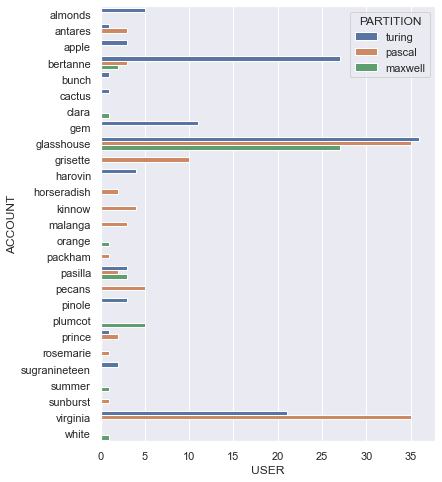

In [40]:
#plotting number of users by partition and account
sns.set(rc={"figure.figsize":(6, 8)})
sns.barplot(
             x='USER',
             y='ACCOUNT',
             hue='PARTITION',
             data=(accre_gpu
                    .groupby(['PARTITION', 'ACCOUNT'])['USER']
                    .nunique()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

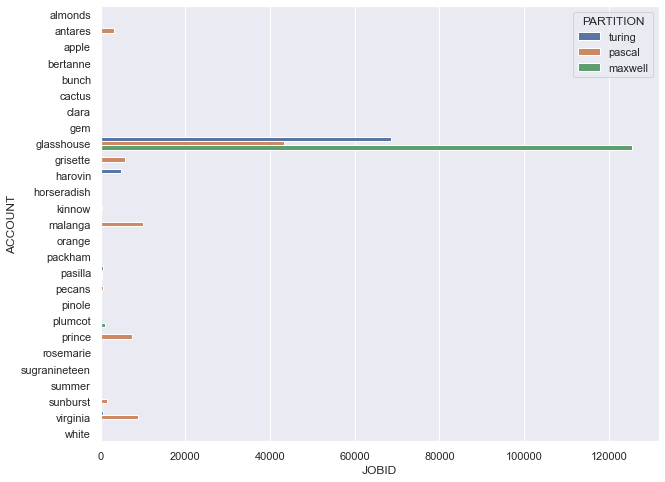

In [41]:
#plotting number of jobs by partition and account
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(
             x='JOBID',
             y='ACCOUNT',
             hue='PARTITION',
             data=(accre_gpu
                    .groupby(['PARTITION', 'ACCOUNT'])['JOBID']
                    .nunique()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

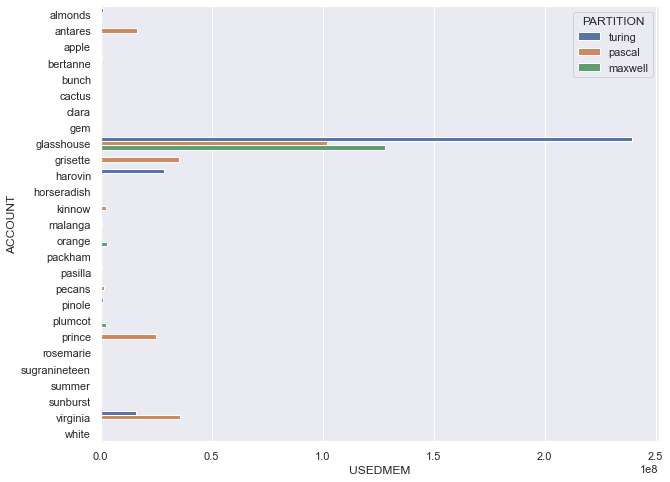

In [42]:
#plotting total memory usage by partition and account
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(
             x='USEDMEM',
             y='ACCOUNT',
             hue='PARTITION',
             data=(accre_gpu
                    .groupby(['PARTITION', 'ACCOUNT'])['USEDMEM']
                    .sum()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

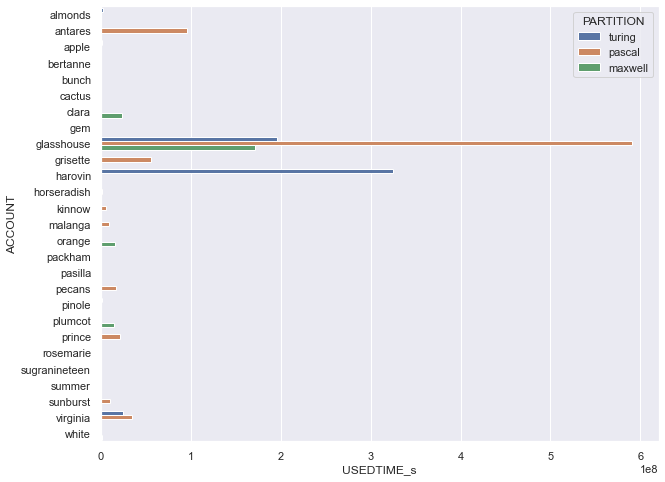

In [44]:
#plotting total time used in minutes by partition and account
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(
             x='USEDTIME_s',
             y='ACCOUNT',
             hue='PARTITION',
             data=(accre_gpu
                    .groupby(['PARTITION', 'ACCOUNT'])['USEDTIME_s']
                    .sum()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

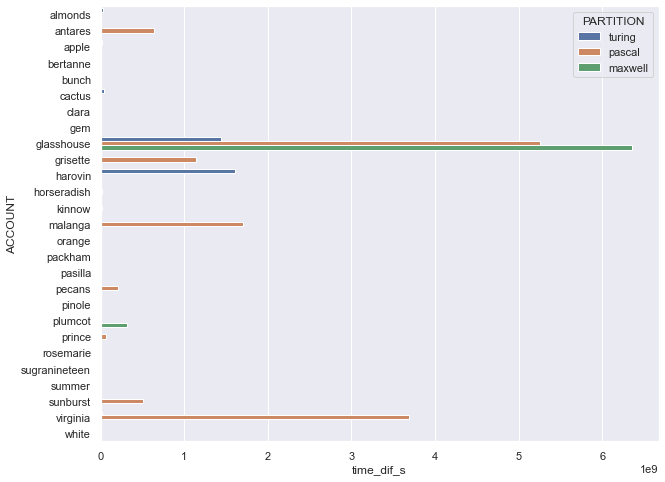

In [46]:
#plotting total time difference in m by partition and account
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(
             x='time_dif_s',
             y='ACCOUNT',
             hue='PARTITION',
             data=(accre_gpu
                    .groupby(['PARTITION', 'ACCOUNT'])['time_dif_s']
                    .sum()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

In [47]:
#number of jobs either completed, failed, or ran out of memory for each user
user_counts = (
    accre_gpu
    .groupby(['PARTITION','ACCOUNT','USER'])['JOBID']
    .count()
    .to_frame()
    .reset_index()
    .sort_values('JOBID', ascending=False)
    .rename(columns={'JOBID':'job_count'})
)
user_counts

,PARTITION,ACCOUNT,USER,job_count
23,maxwell,glasshouse,marnie,112903
219,turing,glasshouse,margret,58931
70,pascal,glasshouse,marnie,24777
99,pascal,malanga,arline,9851
129,pascal,virginia,hillery,8413
...,...,...,...,...
193,turing,gem,leyla,1
195,turing,gem,osborne,1
39,maxwell,summer,pamelia,1
1,maxwell,bertanne,ari,1


Almost half of all jobs in this data set came frome one user in one partition

In [48]:
#total amount of time used for all jobs either completed, failed, or ran out of memory for each user
user_time = (
    accre_gpu
    .groupby(['PARTITION', 'ACCOUNT', 'USER'])['USEDTIME']
    .sum()
    .to_frame()
    .reset_index()
)
user_time

,PARTITION,ACCOUNT,USER,USEDTIME
0,maxwell,bertanne,abigail,1 days 03:46:59
1,maxwell,bertanne,ari,0 days 00:00:00
2,maxwell,clara,suzanna,269 days 07:47:09
3,maxwell,glasshouse,abigail,18 days 06:47:17
4,maxwell,glasshouse,alexandre,0 days 00:01:21
...,...,...,...,...
262,turing,virginia,micayla,5 days 14:42:48
263,turing,virginia,olga,12 days 10:09:35
264,turing,virginia,suzy,0 days 01:41:17
265,turing,virginia,tracy,9 days 02:49:31


In [49]:
#total amount of memory used for all jobs either completed, failed, or ran out of memory for each user
user_memory = (
    accre_gpu
    .groupby(['PARTITION', 'ACCOUNT', 'USER'])['USEDMEM']
    .sum()
    .to_frame()
    .reset_index()
)
user_memory

,PARTITION,ACCOUNT,USER,USEDMEM
0,maxwell,bertanne,abigail,38245.42
1,maxwell,bertanne,ari,400.53
2,maxwell,clara,suzanna,18972.34
3,maxwell,glasshouse,abigail,290807.50
4,maxwell,glasshouse,alexandre,159.86
...,...,...,...,...
262,turing,virginia,micayla,48992.27
263,turing,virginia,olga,4452611.03
264,turing,virginia,suzy,14233.31
265,turing,virginia,tracy,873030.38


In [50]:
#total difference between requested and used time for each user
user_dif = (
    accre_gpu
    .groupby(['PARTITION', 'ACCOUNT', 'USER'])['time_dif']
    .sum()
    .to_frame()
    .reset_index()
)
user_dif

,PARTITION,ACCOUNT,USER,time_dif
0,maxwell,bertanne,abigail,4 days 08:13:01
1,maxwell,bertanne,ari,0 days 04:00:00
2,maxwell,clara,suzanna,76 days 23:50:51
3,maxwell,glasshouse,abigail,136 days 03:12:43
4,maxwell,glasshouse,alexandre,0 days 07:58:39
...,...,...,...,...
262,turing,virginia,micayla,6 days 03:17:12
263,turing,virginia,olga,22 days 02:50:25
264,turing,virginia,suzy,0 days 06:18:43
265,turing,virginia,tracy,13 days 07:10:29


In [51]:
#putting all these user details into a single df
from functools import reduce

dfs=[user_counts, user_memory, user_time, user_dif]

user_details = reduce(lambda left, right: pd.merge(left, right), dfs)

user_details['time_dif_h'] = user_details['time_dif'].astype('timedelta64[h]')

user_details['time_dif_h_per_job'] = user_details['time_dif'].astype('timedelta64[h]')/user_details['job_count']
user_details['mem_per_job'] = user_details['USEDMEM']/user_details['job_count']
user_details['time_per_job'] = user_details['USEDTIME']/user_details['job_count']

user_details['time_weighted_jobs'] = (user_details['USEDTIME'].dt.total_seconds()/86400) * (user_details['job_count'])

user_details

,PARTITION,ACCOUNT,USER,job_count,USEDMEM,USEDTIME,time_dif,time_dif_h,time_dif_h_per_job,mem_per_job,time_per_job,time_weighted_jobs
0,maxwell,glasshouse,marnie,112903,9.399799e+07,210 days 12:00:06,47369 days 17:59:54,1136873.0,10.069467,832.555268,0 days 00:02:41.087003888,2.376609e+07
1,turing,glasshouse,margret,58931,1.980931e+08,388 days 04:32:28,7962 days 07:28:32,191095.0,3.242691,3361.440775,0 days 00:09:29.132510902,2.287638e+07
2,pascal,glasshouse,marnie,24777,3.697431e+07,102 days 07:35:24,22848 days 18:24:36,548370.0,22.132219,1492.283370,0 days 00:05:56.787504540,2.535090e+06
3,pascal,malanga,arline,9851,3.021178e+05,80 days 10:24:25,19621 days 13:35:35,470917.0,47.803979,30.668745,0 days 00:11:45.457821540,7.923516e+05
4,pascal,virginia,hillery,8413,2.671758e+07,75 days 12:51:46,41989 days 11:08:14,1007747.0,119.784500,3175.748918,0 days 00:12:55.740639486,6.354839e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
262,turing,gem,leyla,1,1.213935e+04,0 days 00:40:28,0 days 15:19:32,15.0,15.000000,12139.350000,0 days 00:40:28,2.810185e-02
263,turing,gem,osborne,1,3.626270e+03,0 days 00:10:44,0 days 15:49:16,15.0,15.000000,3626.270000,0 days 00:10:44,7.453704e-03
264,maxwell,summer,pamelia,1,9.266000e+01,2 days 00:00:17,-1 days +23:59:43,-1.0,-1.000000,92.660000,2 days 00:00:17,2.000197e+00
265,maxwell,bertanne,ari,1,4.005300e+02,0 days 00:00:00,0 days 04:00:00,4.0,4.000000,400.530000,0 days 00:00:00,0.000000e+00


In [52]:
user_details.describe()

,job_count,USEDMEM,USEDTIME,time_dif,time_dif_h,time_dif_h_per_job,mem_per_job,time_per_job,time_weighted_jobs
count,267.000000,2.670000e+02,267,267,2.670000e+02,267.000000,267.000000,267,2.670000e+02
mean,1062.831461,2.403162e+06,70 days 12:38:44.985018727,999 days 23:31:08.498127344,2.399896e+04,24.072225,6781.149451,0 days 07:17:15.811326815,3.520897e+05
std,7979.241663,1.413765e+07,267 days 15:33:11.817527732,4865 days 03:16:08.184545408,1.167633e+05,29.668279,14271.235825,0 days 11:57:47.345216323,2.259220e+06
min,1.000000,0.000000e+00,0 days 00:00:00,-41 days +13:07:35,-9.710000e+02,-18.673077,0.000000,0 days 00:00:00,0.000000e+00
25%,3.000000,3.624525e+03,0 days 01:10:07,0 days 14:32:30,1.400000e+01,2.000000,250.136214,0 days 00:12:30.875000,2.524653e-01
50%,21.000000,4.254442e+04,3 days 05:30:20,8 days 14:39:06,2.060000e+02,12.521739,2104.170484,0 days 02:27:33.387990762,4.742986e+01
75%,75.500000,4.020958e+05,20 days 03:32:48.500000,81 days 20:15:25,1.963500e+03,33.164150,6623.732500,0 days 08:25:14.229234844,1.202253e+03
max,112903.000000,1.980931e+08,3003 days 05:30:24,47369 days 17:59:54,1.136873e+06,119.784500,110325.591000,3 days 11:56:42.974025974,2.376609e+07


#### 5. Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [53]:
#how many times did accounts make request for 5 or more days
accre_gpu.loc[accre_gpu['REQTIME'] >= '5 days']['ACCOUNT'].value_counts()

glasshouse     10146
virginia        8514
harovin         4434
antares         1442
grisette         870
plumcot          739
pecans           506
horseradish       47
clara             46
apple             44
kinnow            37
almonds           15
white              5
bertanne           4
pinole             1
Name: ACCOUNT, dtype: int64

In [54]:
#how many times did accounts have time differences between requested/used time of at least 1 day (for any amount of time requested)
accre_gpu.loc[accre_gpu['time_dif'] >= '1 day']['ACCOUNT'].value_counts()

glasshouse       21620
malanga           9889
virginia          8661
harovin           3976
grisette          3200
antares           1743
sunburst          1484
plumcot            751
pecans             503
almonds            106
cactus             101
kinnow              64
horseradish         46
apple               43
rosemarie           31
orange              28
clara               18
pinole               9
bertanne             7
sugranineteen        6
pasilla              3
packham              3
white                3
Name: ACCOUNT, dtype: int64

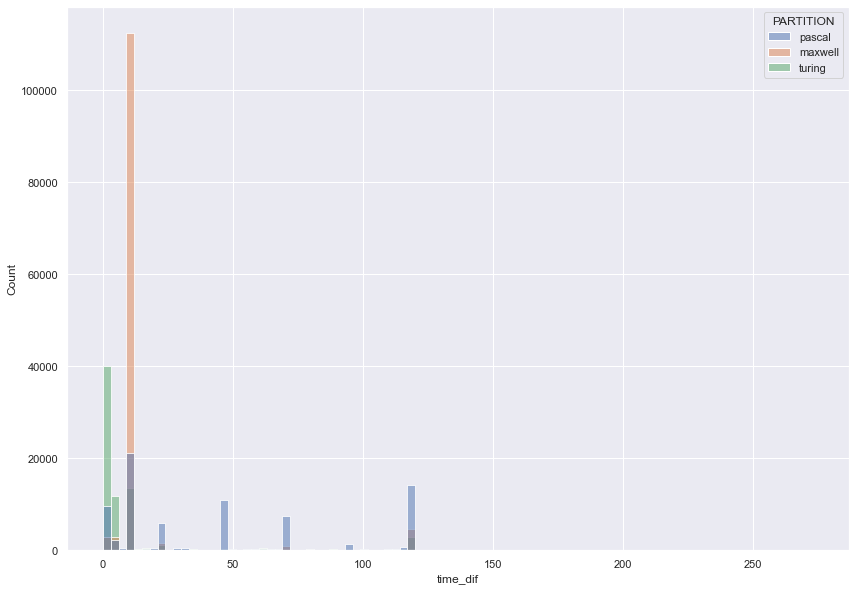

In [56]:
#looking at a plot of the count of different time differences (in hours) with each bin being 3 hours wide
sns.set(rc={"figure.figsize":(14, 10)})
sns.histplot(
    data = accre_gpu.loc[accre_gpu['time_dif_s'] >= 0], 
    x = (accre_gpu['time_dif'].astype('timedelta64[h]')),
    binwidth=3,
    hue = 'PARTITION'
);

Number of 5+ day requests: 
26850


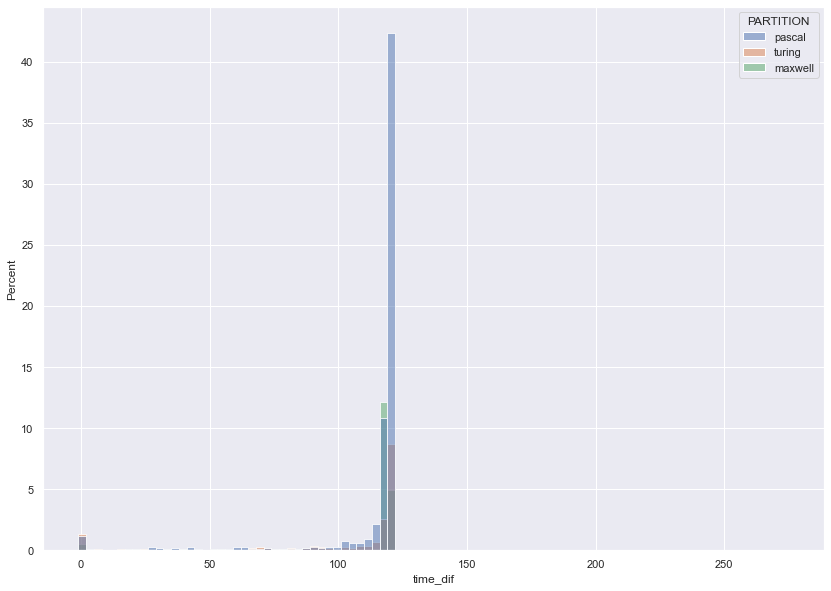

In [57]:
#looking more specifically at requests that are for 5 or more days, bins here are percentage of jobs rather than counts
print("Number of 5+ day requests: ")
print(len(accre_gpu.loc[accre_gpu['REQTIME'] >= '5 days']))
sns.set(rc={"figure.figsize":(14, 10)})
sns.histplot(
    data = accre_gpu.loc[accre_gpu['REQTIME'] >= '5 days'], 
    x = (accre_gpu['time_dif'].astype('timedelta64[h]')),
    stat='percent',
    binwidth=3,
    hue = 'PARTITION'
);

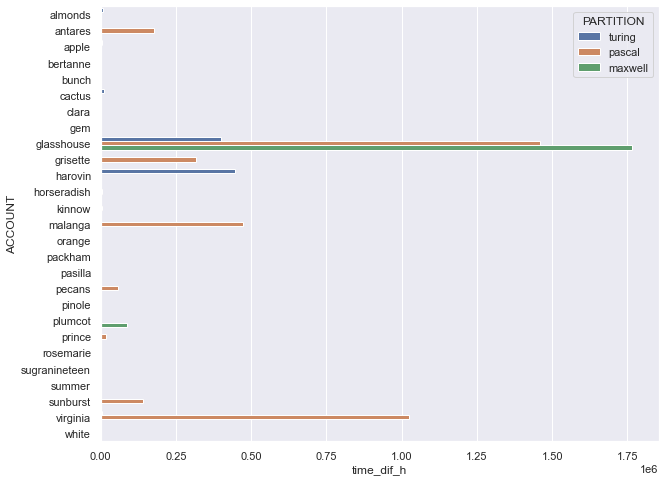

In [58]:
#looking at the sum of all time differences by partition and account
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot(
             x='time_dif_h',
             y='ACCOUNT',
             hue='PARTITION',
             data=(user_details
                    .groupby(['PARTITION', 'ACCOUNT'])['time_dif_h']
                    .sum()
                    .to_frame()
                    .reset_index()
                    .sort_values('ACCOUNT'))
            );

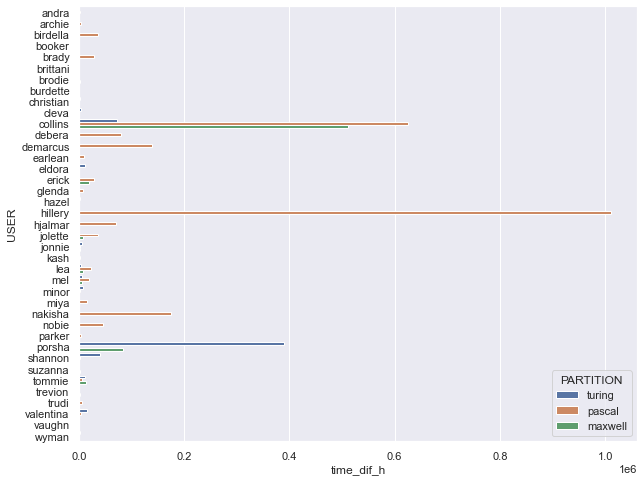

In [59]:
#looking at sum of time differences for those users who have instances of differences of at least 4 days
sns.set(rc={"figure.figsize":(10, 8)})
sns.barplot( x='time_dif_h',
             y='USER',
             hue='PARTITION',
             data=(user_details
                    .loc[user_details['USER']
                         .isin(accre_gpu.loc[accre_gpu['time_dif'] >= '4 days']['USER'])]
                    .groupby(['PARTITION', 'USER'])['time_dif_h']
                    .sum()
                    .to_frame()
                    .reset_index()
                    .sort_values('USER'))
            );